In [40]:
#The main file for case 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Path to main file
file_Moa = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/FALL2_2.TXT"
# path to file for Groundflux
file_G = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/Ground heat flux.txt"
# File for r_a
file_ra12 = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/aerodynamic resistance_12.txt"
file_ra33 = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/aerodynamic resistance_33.txt"
file_ra60 = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/aerodynamic resistance_60.txt"

# Read as space-separated values
df = pd.read_csv(file_Moa, delim_whitespace=True, header=None)
df_G= pd.read_csv(file_G, delim_whitespace=True, header=None)
df_ra12= pd.read_csv(file_ra12, delim_whitespace=True, header=None)
df_ra33= pd.read_csv(file_ra33, delim_whitespace=True, header=None)
df_ra60= pd.read_csv(file_ra60, delim_whitespace=True, header=None)

#retrieve variables
R = df.iloc[:, 22].to_numpy()  # Nettradiationn in column 23
#G= df.iloc[:, 17:23 ] # GROUND HEAT FLUX AT EACH HEGHT in column 18-22 (22 INCLUDED)
G = df_G[0].to_numpy()

r_a12= df_ra12[0].to_numpy()
r_a33= df_ra33[0].to_numpy()  
r_a60= df_ra60[0].to_numpy()    

r_a_list = [
    df_ra12[0].to_numpy(),
    df_ra33[0].to_numpy(),
    df_ra33[0].to_numpy()   #
]

T_g= df.iloc[:,17:23 ].to_numpy()  # GROUND temperature 
p=df.iloc[:, 16].to_numpy()  # air pressure
theta= df.iloc[:, 10:16].to_numpy()  # Potential temperature at different heights
r_l=100
#Constants
rho =  1.225 # kg/m³ - density of air at sea level (is it always the same?)
c_p= 1005 # J/(kg·K) specific heat of air at sea level
gamma= (c_p * p /10) / (0.622 * 2.45*10**6) # kPa /K - psycometric constant γ=cp⋅P/ (ε⋅λ)  (lambda is latent heat of vaporization, epsilon molecular weight of water vapor to dry air)
karman= 0.41


#Changes in different height cases!
h_max= 1.5 #m (approx for barley)
LAI_max= 4 #barley
n= 1 # barley 1-2
heights=[0.12,0.329,0.6]
g= 9.81# m s-2




In [41]:
# help functions

def pottemp_to_temp(theta):
    T=theta * (p/1000)**0.286
    return T


# we calculate difference e_s-e_a
def vapour_pressure_deficit(T): 
    e_s= 0.6108 * np.exp(17.27 * T / (237.3 +T)) #Tetens equation
    T_min=np.min(T)
    e_a= 0.6108 * np.exp(17.27 * T_min / (237.3 +T_min))       #e_s(T_min)
    return e_s-e_a

# slope of the saturation curve
def gradient_e_s (e_s,T): 
    delta= e_s * 4097.871 / (237.3 + T)**2
    return delta


    

In [42]:
# Temperature at level z_1
T_1 = pottemp_to_temp(theta[:, 0]) #in Celsius
e_s= 0.6108 * np.exp(17.27 * T_1 / (237.3 +T_1)) #Tetens equation
e_sa= vapour_pressure_deficit(T_1) # use temperature at the lowest level to find water vapor deficit
delta= gradient_e_s(e_s, T_1)





In [43]:
# Penman eq
ET = np.zeros((len(heights), len(R)), dtype=float)

for idx, h in enumerate(heights):
    # Leaf area and resistance
    d = 0.65*h 
    LAI = LAI_max * (h / h_max)**n
    LAI_active = 0.5 * LAI
    r_s = r_l / LAI_active
    r_a = r_a_list[idx]

    # replace NaNs in r_a with infinity
    r_a = np.where(np.isnan(r_a), np.inf, r_a)

    ET[idx, :] = delta * (R-G) + rho * c_p * e_sa/r_a  / ( delta + gamma * (1 + r_s/ r_a) )

    
np.save("ET_main_data2.npy", ET)


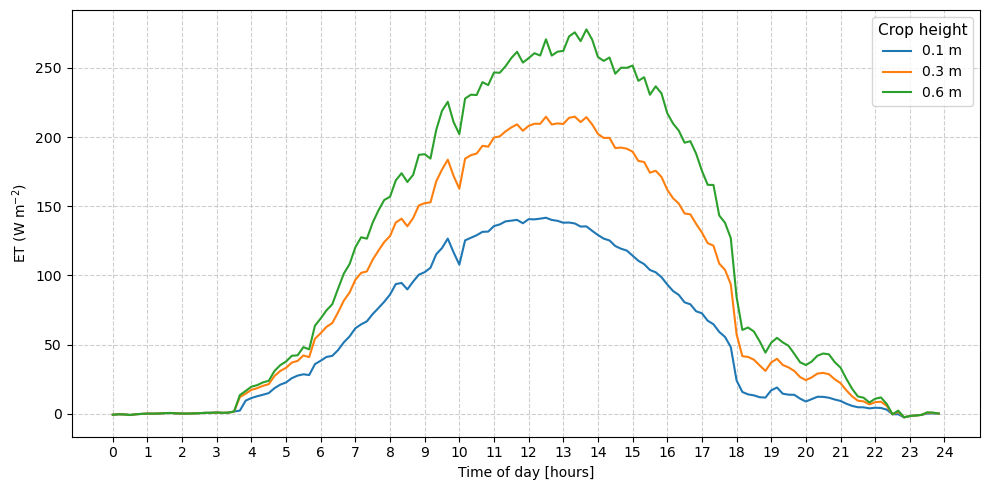

In [44]:
# Continuous time axis in hours (0–24 in 10 min steps)
time_hours = np.arange(0, 24, 10/60)   # 144 points


plt.figure(figsize=(10,5))


for idx, h in enumerate(heights):
    plt.plot(
        time_hours, ET[idx, :],
        label=f"{h:.1f} m",
        linewidth=1.5,
    )

plt.xlabel("Time of day [hours]")
plt.ylabel("ET (W m$^{-2}$)")
#plt.title("Evapotranspiration (ET) over 24h")
plt.grid(True)

# Show ticks every hour
plt.xticks(range(0, 25, 1))
plt.legend(title="Crop height", fontsize=10, title_fontsize=11, loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

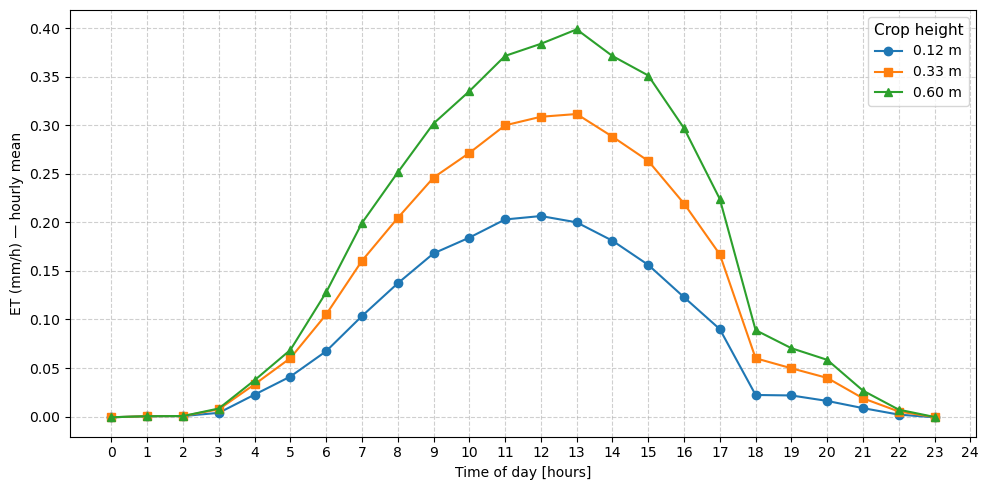

In [45]:
L= 2.45 * 10**6
ET_mm = (ET * 3600) / L

steps_per_hour = 6
total_hours = 24
expected_len = total_hours * steps_per_hour

# Safety: trim to whole hours if needed
ET_mm_trim = ET_mm[:, :expected_len]

# Hourly means: reshape [heights, 24, 6] → mean over the last axis
ET_mm_hourly = ET_mm_trim.reshape(len(heights), total_hours, steps_per_hour).mean(axis=2)

# Hour ticks 0..23
hours = np.arange(total_hours)

# Markers: circle, square, triangle (then cycle if more than 3 heights)
markers = ['o', 's', '^']

plt.figure(figsize=(10,5))

for idx, h in enumerate(heights):
    marker = markers[idx % len(markers)]
    plt.plot(
        hours,
        ET_mm_hourly[idx, :],
        linestyle='-',
        marker=marker,
        label=f"{h:.2f} m"
    )

plt.xticks(range(0, 25, 1))
plt.xlabel("Time of day [hours]")
plt.ylabel("ET (mm/h) — hourly mean")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Crop height", fontsize=10, title_fontsize=11, loc="upper right")
plt.tight_layout()
plt.show()

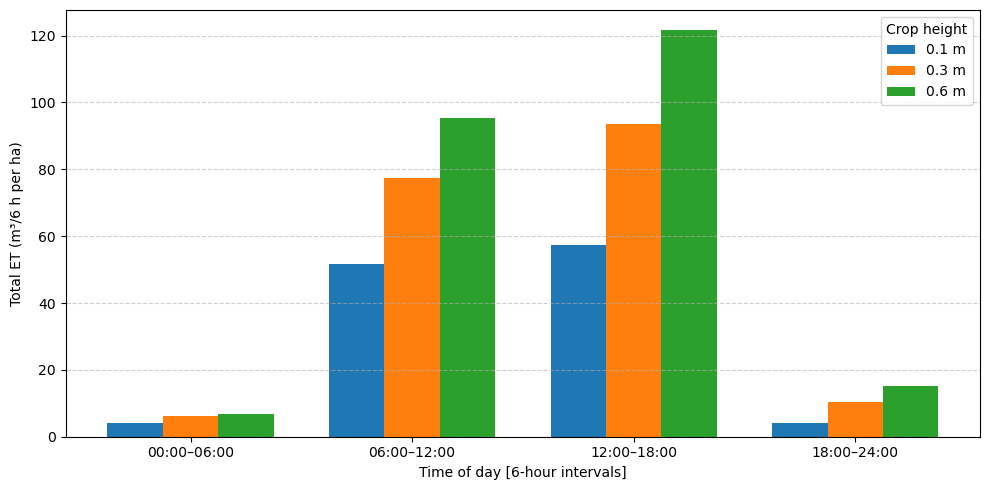

In [46]:
#Cost mm/h -> m^3/period
A= 10000 # m^2 - 1 hectar
E_m=ET_mm * A *0.001 #m^3/h


# 6-hour bin edges (0–6, 6–12, 12–18, 18–24)
bin_edges = np.arange(0, 25, 6)
bin_labels = [f"{bin_edges[i]:02.0f}:00–{bin_edges[i+1]:02.0f}:00" for i in range(len(bin_edges)-1)]

# Number of timesteps per 6 h (10 min resolution → 6*60/10 = 36 steps)
steps_per_bin = 36

ET_m3h = ET_mm * 10  # 1 ha → m³/h

# Aggregate into 6 h sums [heights × 4 bins]
ET_m3h_bins = ET_m3h.reshape(len(heights), 4, steps_per_bin).sum(axis=2)

# Plot as grouped bar chart
x = np.arange(len(bin_labels))  # positions for bins
width = 0.25  # bar width

plt.figure(figsize=(10,5))

for idx, h in enumerate(heights):
    plt.bar(
        x + idx*width,
        ET_m3h_bins[idx, :],
        width=width,
        label=f"{h:.1f} m",
    )

plt.xticks(x + width, bin_labels)
plt.xlabel("Time of day [6-hour intervals]")
plt.ylabel("Total ET (m³/6 h per ha)")
plt.legend(title="Crop height", fontsize=10)
plt.grid(True, linestyle="--", axis="y", alpha=0.6)
plt.tight_layout()
plt.show()

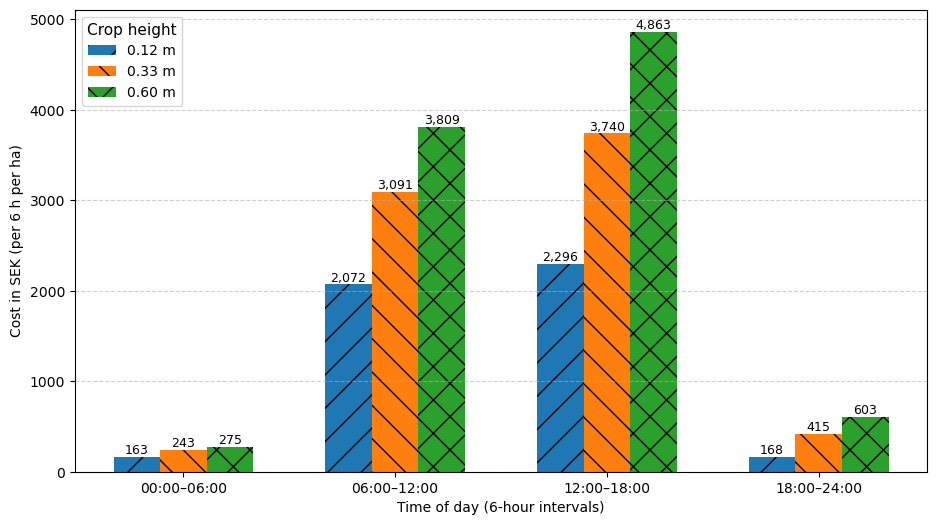

In [47]:
price_per_m3 = 40          # SEK per m³; set to your actual price
bar_width = 0.22            # narrower bars to leave space between groups
hatches = ['/', '\\', 'x', 'o', '.', '*']  # will cycle if more heights than patterns
label_fmt = "{:,.0f}"       # show rounded SEK with thousands sep; e.g., 12,345

# ------------------------
# Binning (6-hour blocks)
# ------------------------
bin_edges = np.arange(0, 25, 6)  # [0, 6, 12, 18, 24]
bin_labels = [f"{bin_edges[i]:02.0f}:00–{bin_edges[i+1]:02.0f}:00" for i in range(len(bin_edges)-1)]

# 10-min steps → 6 * 60 / 10 = 36 steps per 6-h bin
steps_per_bin = 36

# Convert mm/h → m³/h per hectare (1 mm/h over 1 ha = 10 m³/h)
ET_m3h = ET_mm * 10

# Aggregate into 6 h totals [heights × 4 bins]
ET_m3h_bins = ET_m3h.reshape(len(heights), 4, steps_per_bin).sum(axis=2)

# Scale and turn into cost
values = ET_m3h_bins *  price_per_m3   # units: SEK per 6 h per ha

# ------------------------
# Plot
# ------------------------
x = np.arange(len(bin_labels))       # [0,1,2,3] bin centers
group_offset = (np.arange(len(heights)) - (len(heights)-1)/2.0) * bar_width

plt.figure(figsize=(11, 6))

# Bars per height with distinct hatching (no explicit colors)
for idx, h in enumerate(heights):
    positions = x + group_offset[idx]
    bars = plt.bar(
        positions,
        values[idx, :],
        width=bar_width,
        hatch=hatches[idx % len(hatches)],
        label=f"{h:.2f} m",
        linewidth=1.0
    )
    # Add value labels on top of bars
    for r in bars:
        height = r.get_height()
        if np.isfinite(height) and height > 0:
            plt.text(
                r.get_x() + r.get_width()/2.0,
                height,
                label_fmt.format(height),
                ha='center', va='bottom',
                fontsize=9, rotation=0
            )

# X labels and ticks
plt.xticks(x, bin_labels, rotation=0)
plt.xlabel("Time of day (6-hour intervals)")

# Y label and grid
plt.ylabel("Cost in SEK (per 6 h per ha)")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

# Legend and titles
plt.legend(title="Crop height", fontsize=10, title_fontsize=11, loc="upper left", frameon=True)


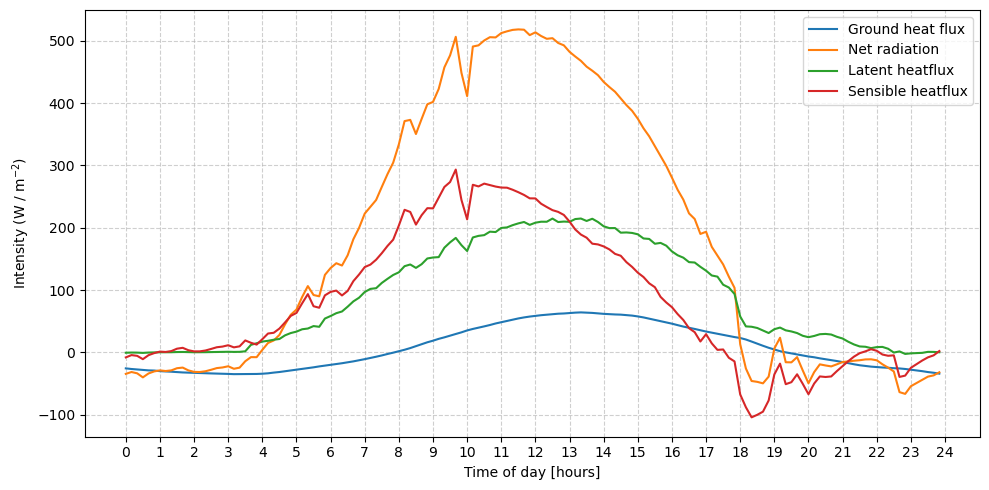

In [48]:
#For crop height 33 cm

# Continuous time axis in hours (0–24 in 10 min steps)
time_hours = np.arange(0, 24, 10/60)   # 144 points


plt.figure(figsize=(10,5))


plt.plot( time_hours, G , label= "Ground heat flux" , linewidth=1.5) #Ground heatflux
plt.plot( time_hours, R , label= "Net radiation" , linewidth=1.5) #Nett radiation
plt.plot( time_hours, ET[1,:]  , label= "Latent heatflux" , linewidth=1.5)  #Latent heat flux
plt.plot( time_hours, (R-G)-ET[1,:], label= "Sensible heatflux" , linewidth=1.5)  #Sensible heat flux

plt.xlabel("Time of day [hours]")
plt.ylabel("Intensity (W / m$^{-2}$)")

plt.grid(True)

# Show ticks every hour
plt.xticks(range(0, 25, 1))
plt.legend( fontsize=10, title_fontsize=11, loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [49]:
# plot richardson number to evaluate stability function phi

U=df.iloc[:, 4:10].to_numpy() #windspeed
Theta= df.iloc[:, 10:16].to_numpy() #pttemp

time = np.arange(np.datetime64('1994-06-14T00'), np.datetime64('1994-06-15T00'), np.timedelta64(10, 'm'))
Height = np.array([0.84,1.95,4.78,10.1,17.2,29.0])
log_height = np.log(Height)

U_gradient_array = np.zeros(len(time))
theta_gradient_array = np.zeros(len(time))
theta_mean_array  = np.zeros(len(time))


def model(x, a, b, c):
    return a + b*x + c*x**2


for time_i in range(len(time)):
    u_vertical_i = U[time_i,:]
    params, covariance = curve_fit(model, log_height,u_vertical_i)
    a_fit, b_fit, c_fit = params

    U_gradient_array[time_i] = b_fit+2*c_fit*np.log(10)/10   # z=10

for time_i in range(len(time)):
    u_vertical_i = Theta[time_i,:]
    params, covariance = curve_fit(model, log_height,u_vertical_i)
    a_fit, b_fit, c_fit = params

    theta_gradient_array[time_i] = (b_fit+2*c_fit*np.log(10))/10   # z=10
    

Ri= g * theta_gradient_array / U_gradient_array **2 #assumtion meridional wind speed=0 at 10m

file_z_L= "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/stability z-L.txt"
df_z_L= pd.read_csv(file_z_L, delim_whitespace=True, header=None)
z_L=df_z_L[0].to_numpy(dtype=float)



def fai_m_compute(yita):
    if (yita<0):
        return (1-16*yita)**(-1/4)
    else:
        return 1+5*yita
    
def fai_h_compute(yita):
    if (yita<0):
        return (1-16*yita)**(-1/2)
    else:
        return 1+5*yita


Ri_shije = np.zeros_like(z_L, dtype=float)

for i, val in enumerate(z_L):
    phi_m_val = fai_m_compute(val)   # works on scalar
    phi_h_val = fai_h_compute(val)   # works on scalar
    Ri_shije[i] = - val * phi_h_val / (phi_m_val**2)



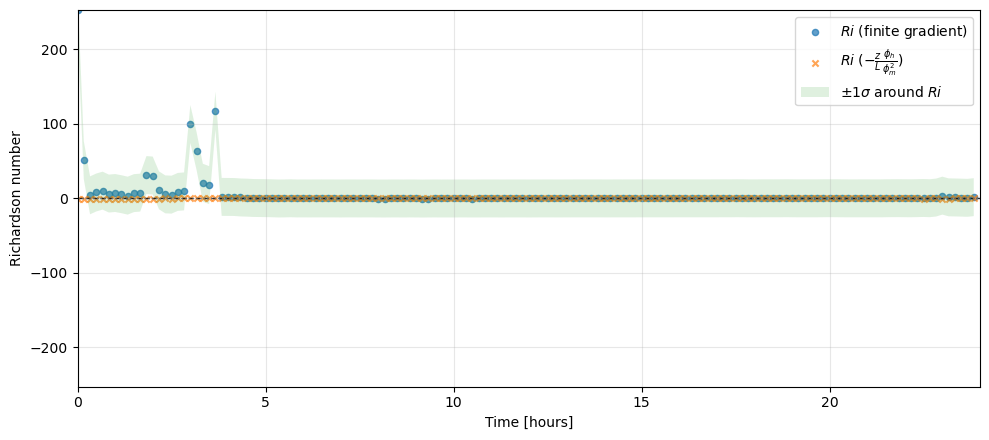

In [50]:
# --- Ensure 1D arrays ---
Ri       = np.ravel(Ri)
Ri_shije = np.ravel(Ri_shije)

# --- Hours axis (10-min step) ---
time_hours = np.arange(0, 24, 10/60)  # 144 points

# --- Align lengths ---
n = min(len(time_hours), len(Ri), len(Ri_shije))
t_plot   = time_hours[:n]
Ri       = Ri[:n]
Ri_shije = Ri_shije[:n]

# --- Optional: mask NaNs so lines/bands don't break ---
mask = np.isfinite(Ri) & np.isfinite(Ri_shije)
t_plot_m = t_plot[mask]
Ri_m     = Ri[mask]
Ri_sh_m  = Ri_shije[mask]

# --- 1-sigma band around Ri (finite-difference) ---
sigma   = np.nanstd(Ri_m)
Ri_up   = Ri_m + sigma
Ri_low  = Ri_m - sigma

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 4.5))

# Scatter plots
ax.scatter(t_plot_m, Ri_m, s=20, alpha=0.7, label=r"$Ri$ (finite gradient)")
ax.scatter(t_plot_m, Ri_sh_m, s=20, alpha=0.7, marker="x",
           label=r"$Ri$ ($-\frac{z}{L}\frac{\phi_h}{\phi_m^2}$)")

# Sigma band
sigma   = np.nanstd(Ri_m)
Ri_up   = Ri_m + sigma
Ri_low  = Ri_m - sigma
ax.fill_between(t_plot_m, Ri_low, Ri_up, alpha=0.15, label=r"$\pm 1\sigma$ around $Ri$")

# Reference lines
ax.axhline(0.0, color="k", linewidth=1, linestyle="--", alpha=0.8)   # zero line
ax.axhline(0.25, linewidth=1, linestyle=":", alpha=0.8, color="gray")

# Center zero in y-axis
yabs = max(abs(np.nanmin(Ri_m)), abs(np.nanmax(Ri_m)))
ax.set_ylim(-yabs, yabs)

ax.set_ylabel("Richardson number")
ax.set_xlabel("Time [hours]")
ax.set_xlim(0, 24)

ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


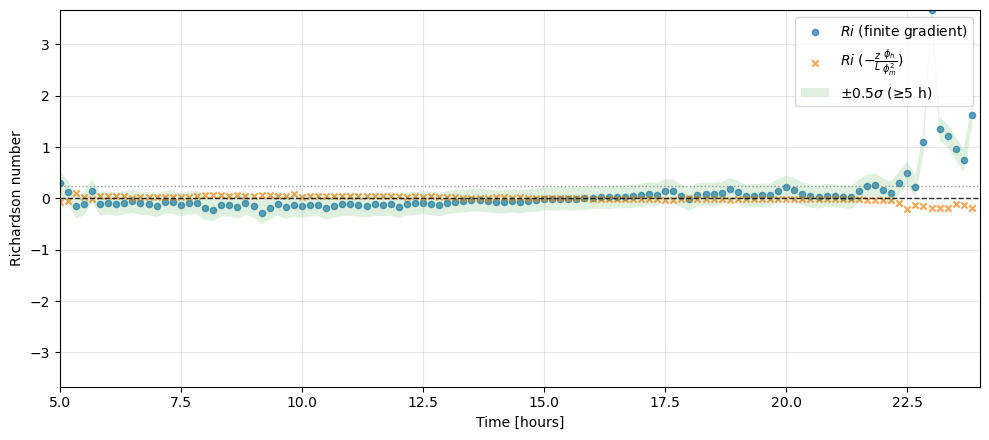

In [51]:
# --- Ensure 1D arrays ---
Ri       = np.ravel(Ri)
Ri_shije = np.ravel(Ri_shije)

# --- Hours axis (10-min step) ---
time_hours = np.arange(0, 24, 10/60)  # 144 points

# --- Align lengths ---
n = min(len(time_hours), len(Ri), len(Ri_shije))
t_plot   = time_hours[:n]
Ri       = Ri[:n]
Ri_shije = Ri_shije[:n]

# --- Mask: finite + time >= 5 h ---
idx_time = t_plot >= 5
mask = idx_time & np.isfinite(Ri) & np.isfinite(Ri_shije)

t_plot_m = t_plot[mask]
Ri_m     = Ri[mask]
Ri_sh_m  = Ri_shije[mask]

# --- Sigma from >= 5 h window ---
sigma = np.nanstd(Ri_m)
Ri_up  = Ri_m + 0.5 *sigma
Ri_low = Ri_m - 0.5 * sigma

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 4.5))

ax.scatter(t_plot_m, Ri_m,    s=20, alpha=0.7, label=r"$Ri$ (finite gradient)")
ax.scatter(t_plot_m, Ri_sh_m, s=20, alpha=0.7, marker="x",
           label=r"$Ri$ ($-\frac{z}{L}\frac{\phi_h}{\phi_m^2}$)")

# Sigma-band (beräknad från >= 5 h)
ax.fill_between(t_plot_m, Ri_low, Ri_up, alpha=0.15, label=r"$\pm 0.5\sigma$ (≥5 h)")

# Referenslinjer
ax.axhline(0.0,  color="k",   linewidth=1, linestyle="--", alpha=0.8)
ax.axhline(0.25, color="gray", linewidth=1, linestyle=":",  alpha=0.8)

# Sätt noll i mitten utifrån >= 5 h-data (utan att krossa detalj)
yabs = max(abs(np.nanmin(Ri_m)), abs(np.nanmax(Ri_m)))
if np.isfinite(yabs) and yabs > 0:
    ax.set_ylim(-yabs, yabs)

ax.set_ylabel("Richardson number")
ax.set_xlabel("Time [hours]")
ax.set_xlim(5, 24)

ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
